### E01 vs ng1 vs ng2

In [ ]:
from nmon import *

In [32]:
EC_shunt = 0.18

EJM_EC = 5
EJN_EC = 5


N_ng1 = 30
N_ng2 = 30

ng1_list = np.linspace(0, 1, N_ng1)
ng2_list = np.linspace(0, 1, N_ng2)

w01_list = np.zeros([N_ng1, N_ng2])

nmon = Nmon(N=1, M=2, EJM=EJM_EC*EC_shunt, EJN=EJN_EC*EC_shunt, EC_shunt=EC_shunt)

for i, ng1 in enumerate(tqdm(ng1_list)):
    for j, ng2 in enumerate(ng2_list):
        for attempt in range(10):
            try:
                nmon.hamiltonian_calc(flux=0, ng=[ng1, ng2], make_plot=False, num_levels=2)
                w01_list[i, j] = nmon.transition_freqs[0]
            except Exception:
                continue
            if w01_list[i, j] != 0:
                break


100%|██████████| 30/30 [08:55<00:00, 17.84s/it]

0.2567819224763157


In [37]:
print((np.max(w01_list) - np.min(w01_list)))

0.21190023003251024


In [34]:
np.save("./data_arrays_ng/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)

In [ ]:
w01_list = np.load("./data_arrays_ng/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )))

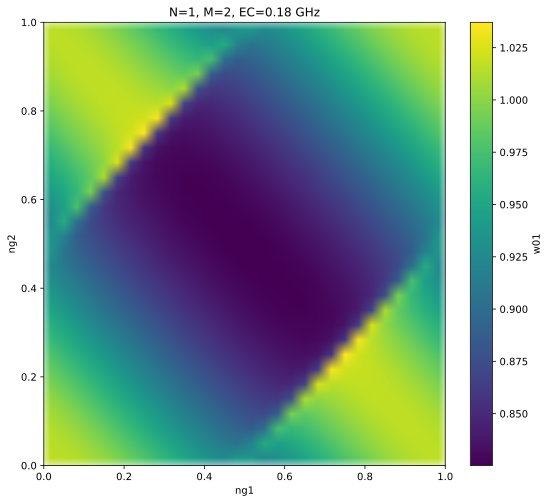

In [41]:
ng1_grid, ng2_grid = np.meshgrid(ng1_list, ng2_list)

plt.figure(figsize=(9, 8))
# Using imshow for pixel plot
plt.imshow(w01_list, origin='lower', aspect='auto',
           extent=[ng1_list.min(), ng1_list.max(), ng2_list.min(), ng2_list.max()],
           cmap='viridis', interpolation='none')
plt.colorbar(label='w01')
plt.xlabel('ng1')
plt.ylabel('ng2')

plt.title("N={}, M={}, EC={} GHz".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )))
# plt.xticks(ticks=np.arange(len(EJM_list[::]))[::2], labels=[f'{round(i/EC_total,1)}' for i in EJM_list[::2]])
# plt.yticks(ticks=np.arange(len(EJN_list[::]))[::2], labels=[f'{round(i/EC_total,1)}' for i in EJN_list[::2]])
plt.savefig("./data_arrays_ng/N={}_M={}_EC_shunt={}_w01_list.pdf".format(nmon.N, nmon.M, round(nmon.EC_shunt, 2)))
plt.show()

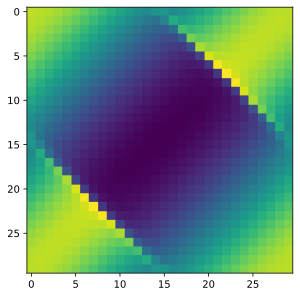

In [42]:
plt.imshow(w01_list)

In [11]:
s = nmon.nmon_circ.sym_hamiltonian(float_round=6)
s, nmon.N, nmon.M, nmon.EJM, nmon.EJN

<IPython.core.display.Latex object>

(None, 1, 2, 19.268209461493687, 1.9268209461493684)

In [9]:
C_matr = nmon.nmon_circ.symbolic_circuit._capacitance_matrix()
C_matr, np.linalg.inv(C_matr)

(array([[ 125.25 , -125.   ],
        [-125.   ,  125.125]]),
 array([[2.66755496, 2.66489007],
        [2.66489007, 2.67021985]]))

In [10]:
nmon.nmon_circ.offset_charge_transformation()

<IPython.core.display.Latex object>

In [12]:
nmon.nmon_circ.variable_transformation()

<IPython.core.display.Latex object>

In [27]:
Matr = nmon.nmon_circ.transformation_matrix

M_inv  = np.linalg.inv(Matr)

Matr, M_inv

(array([[1, 1],
        [1, 0]]),
 array([[ 0.,  1.],
        [ 1., -1.]]))

In [33]:
EC_old_basis = M_inv.T @ np.linalg.inv(C_matr) @ M_inv
EC_old_basis

array([[ 2.67021985, -0.00532978],
       [-0.00532978,  0.00799467]])

In [34]:
import sympy as sp

# Define the symbols for the charge operators and gate-induced charges
n1, n2 = sp.symbols('n1 n2', commutative=False)  # Charge operators (non-commutative if necessary)
ng1, ng2 = sp.symbols('ng1 ng2')  # Gate-induced charges

# Assume EC_new is a 2x2 matrix, define it symbolically
# EC11, EC12, EC21, EC22 = sp.symbols('EC11 EC12 EC21 EC22')
# EC_new = sp.Matrix([[EC11, EC12], [EC21, EC22]])
EC_new = EC_old_basis

# Define the charge operator vectors (add ng to each)
n_vector = sp.Matrix([n1 + ng1, n2 + ng2])

# Construct the Hamiltonian using matrix multiplication for the charging energy terms
H_C = n_vector.T * EC_new * n_vector

# Simplify the expression to make it more readable
H_C_simplified = sp.simplify(H_C[0])  # Access the first element as it results in a 1x1 matrix

# Display the Hamiltonian
H_C_simplified


(0.00799467021985389*(ng2 + n2) - 0.00532978014656882*(ng1 + n1))*(ng2 + n2) + (2.670219853431*(ng1 + n1) - 0.00532978014656926*(ng2 + n2))*(ng1 + n1)

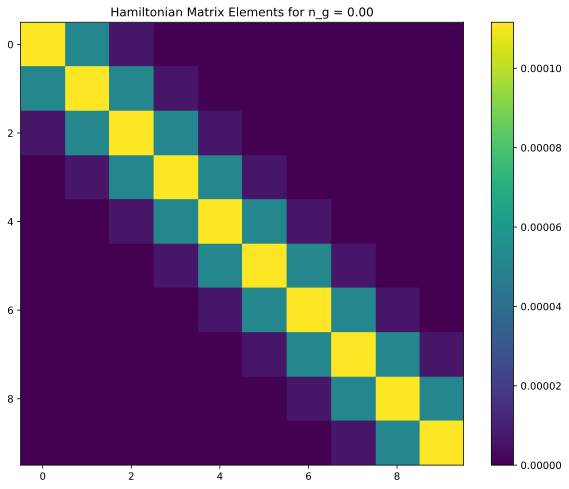

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
E_C = 0.06  # Example value for Charging Energy matrix
E_JN = 4.5  # Josephson Energy
E_JM = 0.9
N = 1  # Number of JJs in the first branch
M = 2  # Number of JJs in the second branch
n_max = 10  # Range of charge states

# Discretization of the phase variable
N_phi = 100
N_phi_trunc = 10
phi = np.linspace(0, 2 * np.pi, N_phi, endpoint=False)

N_ng = 100
# Define charge states and gate charges
n_g_values = np.linspace(-0.1, 0.1, N_ng)

# Define EC as a random symmetric matrix (for demonstration)
# E_C_matrix = np.random.rand(N+M-1, N+M-1)
# E_C_matrix = (E_C_matrix + E_C_matrix.T) / 2  # Ensure it is symmetric

E_C_matrix = EC_old_basis # E_C*np.array([[0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1]])

# Function to create derivative operator with scaled phase variable
def create_derivative_operator(scaling_factor):
    h_phi_scaled = 2 * np.pi / (N_phi) * scaling_factor
    d_dphi_scaled = -1j * (np.diag(np.ones(N_phi - 1), 1) - np.diag(np.ones(N_phi - 1), -1)) / (2 * h_phi_scaled)
    d_dphi_scaled[0, -1] = -1j / (2 * h_phi_scaled)  # Periodic boundary condition
    d_dphi_scaled[-1, 0] = 1j / (2 * h_phi_scaled)
    return d_dphi_scaled

# Create derivative operators for N and M scaling
d_dphi_N = create_derivative_operator(N)
d_dphi_M = create_derivative_operator(M)

# Initialize the Hamiltonian array for each gate charge
H_matrices = np.zeros((N_phi, N_phi, len(n_g_values)), dtype=complex)

num_n_g = 0

# Construct the Hamiltonian iteratively for each gate charge
for idx, n_g in enumerate(n_g_values):
    H_kinetic = np.zeros((N_phi, N_phi), dtype=complex)
    for i in range(N + M - 1):
        for j in range(N + M - 1):
            n_operator_i = d_dphi_N if i < N else d_dphi_M  # Choose the correct scaled operator
            n_operator_j = d_dphi_N if j < N else d_dphi_M
            H_kinetic += 4*E_C_matrix[i, j] * (n_operator_i/1e4 - n_g *(i == num_n_g) * np.eye(N_phi)).conj().T @ (n_operator_j/1e4 - n_g * (j == num_n_g)* np.eye(N_phi))

    # Josephson terms with scaled cosine and sine matrices
    phi = np.linspace(0, 2 * np.pi, N_phi, endpoint=False)
    cos_phi_N = np.diag(np.cos(N * phi))
    cos_phi_M = np.diag(np.cos(M * phi))
    H_Josephson = 0*( -M * E_JM * cos_phi_N - N * E_JN * cos_phi_M)
    
    # Total Hamiltonian for this gate charge
    H_matrices[:, :, idx] = H_kinetic + H_Josephson

# print(H_matrices[:, :, N_ng//2+1])
# Numerically differentiate the Hamiltonian with respect to n_g
dH_dng = np.gradient(H_matrices, n_g_values, axis=2)

# Select the derivative at the central n_g value
dH_dng_at_ng0 = dH_dng[:N_phi_trunc, :N_phi_trunc, N_ng//2]  # assuming n_g0 corresponds to the middle index

matrix_elements = H_matrices[:N_phi_trunc, :N_phi_trunc, N_ng//2+1]
# print(matrix_elements)
# Example visualization for a selected gate charge
selected_idx = len(n_g_values) // 2
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(matrix_elements), cmap='viridis')
plt.colorbar()
plt.title(f'Hamiltonian Matrix Elements for n_g = {n_g_values[selected_idx]:.2f}')
# plt.xlabel('Phase (radians)')
# plt.ylabel('Charge State')
plt.show()
